In [1]:
from geopy.geocoders import Nominatim
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import contextily as ctx
import pandas as pd

def get_coordinates(city_name, state='Pará', country='Brasil'):
    geolocator = Nominatim(user_agent="my_geocoder")
    location = geolocator.geocode(f"{city_name}, {state}, {country}")
    if location:
        return location.latitude, location.longitude
    else:
        return None, None

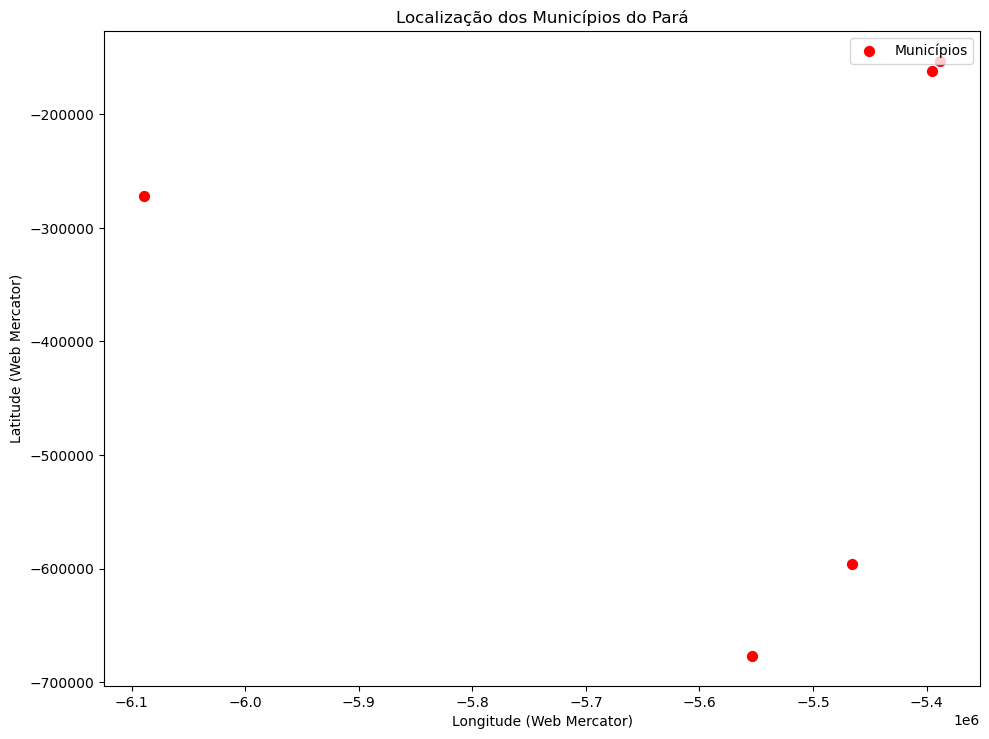

In [2]:
#df= pd.read_csv("Dataset_de_200_Comunidades_para_Analise_Ambiental.csv")


municipios = ['Belém', 'Ananindeua', 'Santarém', 'Marabá', 'Parauapebas']  # Sua lista de municípios
#municipios = df['Município']
coordenadas = {}
for municipio in municipios:
  lat, lon = get_coordinates(municipio)
  if lat and lon:
    coordenadas[municipio] = (lat, lon)
        #print(f"Coordenadas de {municipio}: Latitude={lat:.2f}, Longitude={lon:.2f}"
  else:
        print(f"Não foi possível encontrar as coordenadas de {municipio}")

geometry = [Point(lon, lat) for lat, lon in coordenadas.values()]
municipios_df = gpd.GeoDataFrame(list(coordenadas.keys()), geometry=geometry, columns=['Município'], crs="EPSG:4326")

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

municipios_df = municipios_df.to_crs(epsg=3857)  # Convert to Web Mercator

municipios_df.plot(ax=ax, marker='o', color='red', markersize=50, label='Municípios')


ax.set_xlabel("Longitude (Web Mercator)")
ax.set_ylabel("Latitude (Web Mercator)")
ax.set_title("Localização dos Municípios do Pará")
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [6]:
df

,Comunidade,Município,Estado,Índice de Desmatamento (%),Acesso à Água Potável (%),Cobertura Vegetal (%),Renda Média Mensal (R$),Densidade Populacional (hab/km²),Frequência de Queimadas (ano),Distância de Área Urbana (km),Presença de Escola (Sim/Não),Presença de Unidade de Saúde (Sim/Não)
0,Comunidade 1,SÃO DOMINGOS DO CAPIM,Pará,25.6,86.5,22.9,2863.0,123.2,0,74.7,Sim,Não
1,Comunidade 2,SALINÓPOLIS,Pará,12.9,99.3,21.8,799.0,120.3,11,87.3,Sim,Não
2,Comunidade 3,TRACUATEUA,Pará,81.3,58.9,64.5,1924.0,104.8,5,43.9,Não,Sim
3,Comunidade 4,SÃO MIGUEL DO GUAMÁ,Pará,81.5,56.0,25.5,1715.0,42.3,0,5.3,Sim,Sim
4,Comunidade 5,MAGALHÃES BARATA,Pará,58.8,84.3,39.4,1990.0,89.4,9,17.0,Sim,Sim
...,...,...,...,...,...,...,...,...,...,...,...,...
195,Comunidade 196,MOJUÍ DOS CAMPOS,Pará,67.5,74.3,25.4,2293.0,17.2,2,20.5,Sim,Sim
196,Comunidade 197,PORTO DE MOZ,Pará,73.3,46.8,87.2,1688.0,140.7,9,48.4,Não,Sim
197,Comunidade 198,TUCURUÍ,Pará,29.0,35.3,59.6,2190.0,103.8,2,20.3,Sim,Sim
198,Comunidade 199,CURUÇÁ,Pará,20.1,39.0,44.1,1531.0,12.0,6,17.5,Sim,Sim


In [3]:
import pandas as pd
import folium
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderServiceError



# Função para obter as coordenadas geográficas com tratamento de erros
def get_coordinates(city_name, state='Pará', country='Brasil', max_retries=3, timeout=5):
    for attempt in range(max_retries):
        try:
            location = geolocator.geocode(f"{city_name}, {state}, {country}", timeout=timeout)
            if location:
                return location.latitude, location.longitude
            return None, None
        except GeocoderTimedOut:
            print(f"Timeout ao geocodificar {city_name}, tentativa {attempt + 1}/{max_retries}...")
            if attempt < max_retries - 1:
                import time
                time.sleep(2 ** attempt)  # Espera exponencial
        except GeocoderServiceError as e:
            print(f"Erro de serviço ao geocodificar {city_name}: {e}")
            return None, None
        except Exception as e:
            print(f"Erro inesperado ao geocodificar {city_name}: {e}")
            return None, None
    print(f"Falha ao geocodificar {city_name} após {max_retries} tentativas.")
    return None, None



df= pd.read_csv("Dataset_de_200_Comunidades_para_Analise_Ambiental.csv")

gp1= df.groupby('Município')[df.columns[8]].agg(['mean']).reset_index().sort_values('mean', ascending=False) 

df_par =gp1[['Município','mean']]

# Inicializar o geocodificador Nominatim
geolocator = Nominatim(user_agent="geo_localizador_belém")



# Obter as coordenadas para cada município
municipio_coords = {}
for index, row in df_par.iterrows():
    municipio = row['Município']
    coords = get_coordinates(municipio)
    if coords:
        municipio_coords[municipio] = (coords[0], coords[1], row['mean'])
        print(f"Coordenadas de {municipio}: Latitude={coords[0]:.2f}, Longitude={coords[1]:.2f},{row['mean']:.2f}%")
    else:
        print(f"Não foi possível encontrar as coordenadas de {municipio}")

# Criar um mapa centrado no Pará
para_center_lat = -3.79
para_center_lon = -52.00
m = folium.Map(location=[para_center_lat, para_center_lon], zoom_start=6)

# Adicionar marcadores para cada município com 
# for municipio, data in municipio_coords.items():
#     lat, lon, queimadas = data
#     color = 'green'
#     if queimadas > 3:
#         color = 'yellow'
#     if queimadas > 6:
#         color = 'orange'
#     if queimadas > 9:
#         color = 'red'

#     folium.CircleMarker(
#         location=[lat, lon],
#         radius=queimadas * 1.5,  # Ajustar o raio para melhor visualização
#         color=color,
#         fill=True,
#         fill_color=color,
#         fill_opacity=0.6,
#         popup=f"{municipio}: {queimadas:.2f}% de queimadas"
#     ).add_to(m)

# Exibir o mapa
m

FileNotFoundError: [Errno 2] No such file or directory: 'Dataset_de_200_Comunidades_para_Analise_Ambiental.csv'

In [9]:
# Adicionar marcadores para cada município com informações de desmatamento
for municipio, data in municipio_coords.items():
    lat, lon, desmatamento = data
    color = 'green'
    if desmatamento > 30:
        color = 'orange'
    if desmatamento > 60:
        color = 'red'

    folium.CircleMarker(
        location=[lat, lon],
        radius=desmatamento * 1.5,  # Ajustar o raio para melhor visualização
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.6,
        popup=f"{municipio}: {desmatamento:.2f}% de desmatamento"
    ).add_to(m)

# Exibir o mapa
m